Quickpass system simulation and comparison with single server single queue system.

Libraries used:


1.   numpy
2.   pandas
3.   matplotlib



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.close()

generator methods:

1. generate_dealy() generates a random delay from a normal distribution
2. generate_interarrival() generates a random interarrival time from an exponential distribution
3. generate_service()  generates a random service time from an exponential distribution

In [2]:
def generate_delay(): 
    return abs(np.random.normal(0, 0.1))


def generate_interarrival():
    return np.random.exponential(1. / mean_arrival_num)


def generate_service():
    return np.random.exponential(1. / mean_service_num)

Class Simulation is responsible for orchestrating the simulation and producing results.
It has mainly:
1. A constructor to initialize the state of the system
2. handle_arrival_event() to handle arrivals
3. handle_depart_event() to handle departures
4. generate_return() to genarate a quickpass return

In [3]:
class Simulation:

    def __init__(self):
        self.num_in_system = 0
        self.clock = 0.0
        self.t_arrival = generate_interarrival()
        self.t_depart = float('inf')
        self.num_arrivals = 0
        self.num_departs = 0
        self.total_wait = 0.0
        self.regular_wait = 0.0
        self.quickpass = []
        self.quick_wait = 0.0
        self.quick_start = 0.0
        self.quick_done = 0.0
        self.quick_counter = 0
        self.quick_counter2 = 0
        self.cm_start = 0.0
        self.cm_desk = 0.0

    def advance_time(self):
        t_event = min(self.t_arrival, self.t_depart)
        self.total_wait += self.num_in_system * (t_event - self.clock)
        self.clock = t_event
        if self.t_arrival <= self.t_depart:
            self.handle_arrival_event()
        else:
            self.handle_depart_event()

    def handle_arrival_event(self):
        self.num_in_system += 1
        self.num_arrivals += 1
        self.cm_start = self.clock
        if self.num_in_system > threshold_control and quick_switch == 1:  # QuickPass opens
            self.quick_start = self.clock
            rt = self.generate_return()
            self.quickpass.append(rt)
            self.quick_counter += 1
            self.num_in_system -= 1
        elif self.num_in_system <= 1:
            self.cm_desk = self.t_depart
            self.t_depart = self.clock + generate_service()
        self.t_arrival = self.clock + generate_interarrival()

    def handle_depart_event(self):
        if self.quickpass and self.clock >= self.quickpass[0] and quick_switch == 1:  # CM being served from QuickPass
            self.cm_desk = self.t_depart
            self.t_depart = self.clock + generate_service()
            self.quick_counter2 += 1
            self.quick_done = self.t_depart
            self.quick_wait = self.quick_done - self.quick_start
            del self.quickpass[0]
            self.num_in_system -= 1
            self.num_departs += 1
        else:
            if self.num_in_system > 0:
                self.cm_desk = self.t_depart
                self.t_depart = self.clock + generate_service()
                self.regular_wait = self.t_depart - self.cm_start
                self.num_in_system -= 1
                self.num_departs += 1
            else:
                self.t_depart = float('inf')

    def generate_return(self):
        return self.clock + generate_delay() + self.num_in_system / mean_service_num  # Rt = t0 + t + Lq/Mu


Simulation system parameters are set up in the below cell.
Using the apt value for quick_switch variable we can toggle between normal queue and quickpass queue.

In [4]:
mean_arrival_num = 1.5   # no. of arrivals per minute
mean_service_num = 1  # no. of services completed per minute
threshold_control = 10  # max customers in queue while QuickPass is in action
quick_switch = 1   # 0 for regular queue | 1 for QuickPass in action
seed = 34  # random seed
np.random.seed(seed)

Simulation is setup and various arrays to capture data are initialized. The clock is run and the advance_time method of Simulation object is triggered to update the states. After every advance the parameters are recorded.

In [5]:
s = Simulation()

clock_data = []
num_in_sys_data = []
arrival_time_data = []
departure_time_data = []
arrival_no_data = []
departure_no_data = []
wait_time_data = []
regular_wait_data = []
quick_wait_data = []
wait_in_line = []
queue_wait = []

# running the simulation for the defined period
while s.clock < 240.0:
    previous_depart = s.t_depart

    s.advance_time()

    queue_wait.append(max(0, previous_depart - s.t_arrival))
    quick_wait_data.append(s.quick_wait)
    regular_wait_data.append(s.regular_wait)
    clock_data.append(float(s.clock))
    num_in_sys_data.append(float(s.num_in_system))
    arrival_time_data.append(float(s.t_arrival))
    departure_time_data.append(float(s.t_depart))
    arrival_no_data.append(float(s.num_arrivals))
    departure_no_data.append(float(s.num_departs))

The collected results are organized into dataframes and saved as csv files. The results are also plotted as a graph.


Number of customers departed: 254
Average time in system: 1.611896

- QuickPass info -
Average wait time in QuickPass: 8.103054
Average overall wait time: 3.183973
No. sent to QuickPass queue: 73
No. served from QuickPass queue: 61


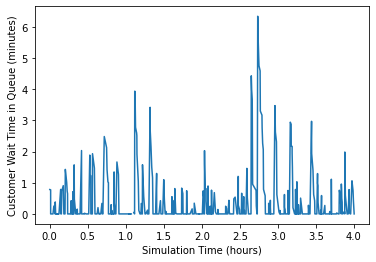

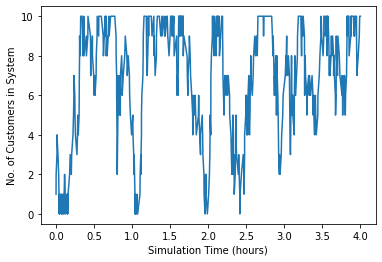

In [6]:
# calculating the system outputs for evaluation
quick_wait = list(set(quick_wait_data))
regular_wait = list(set(regular_wait_data))
all_wait = regular_wait + quick_wait

table_data = [clock_data, num_in_sys_data, arrival_time_data, departure_time_data,
              arrival_no_data, departure_no_data, all_wait,
              regular_wait, quick_wait, queue_wait]

event_table = pd.DataFrame.from_records(table_data)
et = event_table.transpose()
et.columns = ['Time', 'No. in System', 'Arrival Time', 'Departure Time',
              'No. of Arrivals', 'No. of Departures', 'Overall Wait', 'System Time',
              'QuickPass Wait', 'Wait Time in Queue']
if quick_switch == 1:
    et.to_csv('event_table_QuickPass.csv')
else:
    et.to_csv('event_table_Regular.csv')

plt.figure()
plt.plot(np.divide(clock_data, 60), queue_wait)
plt.xlabel('Simulation Time (hours)')
plt.ylabel('Customer Wait Time in Queue (minutes)')

plt.figure()
plt.plot(np.divide(clock_data, 60), num_in_sys_data)
plt.xlabel('Simulation Time (hours)')
plt.ylabel('No. of Customers in System')

if quick_switch == 0:
    print('\nNumber of customers departed: %g' % departure_no_data[-1])
    print('Average time in system: %f' % np.mean(regular_wait))
elif quick_switch == 1:
    print('\nNumber of customers departed: %g' % departure_no_data[-1])
    print('Average time in system: %f' % np.mean(regular_wait))
    print('\n- QuickPass info -')
    print('Average wait time in QuickPass: %f' % np.mean(quick_wait))
    print('Average overall wait time: %f' % np.mean(all_wait))
    print('No. sent to QuickPass queue: %g' % s.quick_counter)
    print('No. served from QuickPass queue: %g' % s.quick_counter2)
